In [1]:
import torch
import random
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
words = open('names.txt','r').read().splitlines()

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(
        f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}"
    )

In [11]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

# lets make a neural network
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)  # create embedding
W1 = (
    torch.randn((block_size * n_embd, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)  # create the first layer of the neural network
b1 = torch.randn(n_hidden, generator=g) * 0.1

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g)* 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [10]:
batch_size = 32
n = batch_size  # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

In [16]:
Xb.shape

torch.Size([32, 3])

In [72]:
# forward pass of the neural network

emb = C[Xb]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = (
    1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
)  # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# add nonlinearity
h = torch.tanh(hpreact)
# calculating logits
logits = h @ W2 + b2
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = (
    counts_sum**-1
)  # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

for p in parameters:
    p.grad = None
for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,  # afaik there is no cleaner way
    norm_logits,
    logit_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnvar_inv,
    bnvar,
    bndiff2,
    bndiff,
    hprebn,
    bnmeani,
    embcat,
    emb,
]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3548, grad_fn=<NegBackward0>)

In [84]:
bnmeani.shape, bndiff.shape, hprebn.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([32, 64]))

In [94]:
embcat.shape, hprebn.shape, W1.shape, b1.shape

(torch.Size([32, 30]),
 torch.Size([32, 64]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [103]:
print(emb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


In [105]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n
dprobs = (1 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)  # dprob/dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts_sum = (
    -(counts_sum**-2)
) * dcounts_sum_inv  # dcounts_sum_inv/dcounts_sum = local derivative * chain
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts  # dcounts/dnorm_logits = e**x * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = -dnorm_logits.sum(1, keepdim=True)
dlogitstemp = torch.zeros_like(logits)
dlogitstemp[range(n), logits.max(1).indices] = 1.0
dlogits += dlogitstemp * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0, keepdim=True)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)
dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
dbndiff = bnvar_inv * dbnraw
dbndiff2 = (1 / (n - 1) * torch.ones_like(bndiff)) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2
dbnmeani = (-dbndiff).sum(0, keepdims=True)
dhprebn = dbndiff.clone()
dhprebn += 1/n * (torch.ones_like(hprebn)*dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for i in range(Xb.shape[1]):
        ix =Xb[k,i]
        dC[ix]+= demb[k,i]
cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("h", dh, h)
cmp("W2", dW2, W2)
cmp("b2", db2, b2)
cmp("hpreact", dhpreact, hpreact)
cmp("bngain", dbngain, bngain)
cmp("bnbias", dbnbias, bnbias)
cmp("bnraw", dbnraw, bnraw)
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)
cmp("bnvar", dbnvar, bnvar)
cmp("bndiff2", dbndiff2, bndiff2)
cmp("bndiff", dbndiff, bndiff)
cmp("bnmeani", dbnmeani, bnmeani)
cmp("hprebn", dhprebn, hprebn)
cmp("embcat", dembcat, embcat)
cmp("W1", dW1, W1)
cmp("b1", db1, b1)
cmp("emb", demb, emb)
cmp("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [107]:
import torch.nn.functional as F

In [108]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), "diff:", (loss_fast - loss).item())

3.3548083305358887 diff: 2.384185791015625e-07


In [112]:
# EExcercise 2 implement the backward pass based on the shortened formula
dlogits = F.softmax(logits,1)
dlogits[range(n), Yb] -= 1.0
dlogits /= n
cmp('dlogits', dlogits, logits)

dlogits         | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [113]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = (
    bngain
    * (hprebn - hprebn.mean(0, keepdim=True))
    / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5)
    + bnbias
)
print("max diff:", (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [115]:
# backward pass simpler formulae
dhprebn = (
    bngain
    * bnvar_inv
    / n
    * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
)

cmp(
    "hprebn", dhprebn, hprebn
)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [163]:
# Putting it all together in one training step and loop
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

# lets make a neural network
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)  # create embedding
W1 = (
    torch.randn((block_size * n_embd, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)  # create the first layer of the neural network
b1 = torch.randn(n_hidden, generator=g) * 0.1

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True
    

max_steps = 200000
batch_size = 32
n = batch_size
lossi = []
with torch.no_grad():
    for i in range(max_steps):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y
        # forward pass
        emb = C[Xb]  # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1  # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5) ** -0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact)  # hidden layer
        logits = h @ W2 + b2  # output layer
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward()

        # gradients which are calculated manually using chain rule and other derivatives
        dlogits = F.softmax(logits,1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1.0 - h**2) * dh
        dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
        dbnbias = dhpreact.sum(0, keepdims=True)
        dhprebn = (
            bngain
            * bnvar_inv
            / n
            * (
                n * dhpreact
                - dhpreact.sum(0)
                - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0)
            )
        )
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k, j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        lr = 0.1 if i < 100000 else 0.01
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad
        if i % 10000 == 0:  # print every once in a while
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())

4137
      0/ 200000: 3.3466
  10000/ 200000: 2.4455
  20000/ 200000: 2.1117
  30000/ 200000: 2.2936
  40000/ 200000: 2.3121
  50000/ 200000: 2.1107
  60000/ 200000: 2.2458
  70000/ 200000: 2.4967
  80000/ 200000: 2.2105
  90000/ 200000: 2.3074
 100000/ 200000: 2.0679
 110000/ 200000: 1.8890
 120000/ 200000: 1.9583
 130000/ 200000: 2.5399
 140000/ 200000: 1.8877
 150000/ 200000: 2.1814
 160000/ 200000: 2.1094
 170000/ 200000: 2.2874
 180000/ 200000: 1.9482
 190000/ 200000: 2.0887


In [129]:
h.shape, W2.shape, dlogits.shape

(torch.Size([32, 64]), torch.Size([64, 27]), torch.Size([32, 27]))

In [158]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [161]:
import matplotlib.pyplot as plt

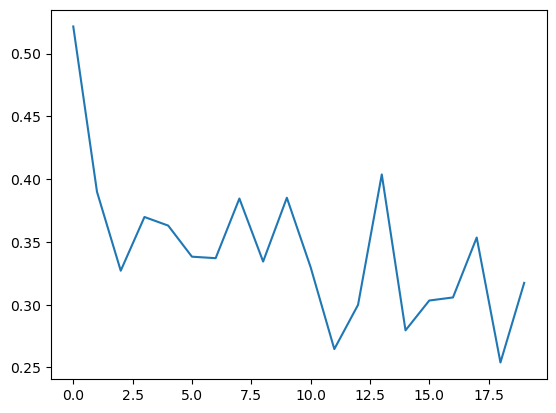

In [162]:
plt.plot(lossi)

In [159]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.145622968673706
val 2.158543825149536


In [160]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
        h = torch.tanh(hpreact)  # (N, n_hidden)
        logits = h @ W2 + b2  # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

mora.
mayah.
see.
madhayla.
reisha.
endra.
graderedielii.
shi.
jen.
eden.
san.
naraelynn.
honia.
nosadhvogiaghie.
trickentelinn.
terofkus.
kaven.
jamelizel.
yuma.
myston.
